计算生态损失度

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import geopandas as gpd
import os

In [2]:
data_base_dir = r"E:\risk_evaluation\scripts\outputs"

In [3]:
n_number_list = []
for i in range(2000,2016):
    for j in range(1,10):
        n_number_list.append(np.load(os.path.join(data_base_dir, "CLCD_N_NUMBER", str(i)+"_"+str(j)+".npy")))

In [4]:
area_of_types = []
for i in range(2000,2016):
    for j in range(1,10):
        area_of_types.append(np.load(os.path.join(data_base_dir, "CLCD_AREA_OF_TYPES", str(i)+"_"+str(j)+"_area.npy")))

In [5]:
n_number_array = np.array(n_number_list)
area_of_types_array = np.array(area_of_types)

In [6]:
n_number_array[np.where(area_of_types_array==0)] = 0
C_i = (n_number_array-1)/(area_of_types_array)

C:\Users\zyzh0\AppData\Local\Temp\ipykernel_9308\4060624109.py:2: RuntimeWarning: divide by zero encountered in divide
  C_i = (n_number_array-1)/(area_of_types_array)


In [7]:
#plt.imshow(area_of_types_array[0])
#plt.colorbar()

In [8]:
#plt.imshow(n_number_array[0])
#plt.colorbar()

In [9]:
#plt.imshow(C_i[0])
#plt.colorbar()

In [10]:
total_area = area_of_types_array.reshape(16,9,2420,2010).sum(axis=1)
total_area_repeated_list = []
for i in range(0,16):
    to_append = total_area[i]
    for j in range(9):
        total_area_repeated_list.append(to_append)

total_area_repeated = np.array(total_area_repeated_list)

In [11]:
N_i = 0.5*np.sqrt(n_number_array/total_area_repeated)*(total_area_repeated/area_of_types_array)

C:\Users\zyzh0\AppData\Local\Temp\ipykernel_9308\1192702399.py:1: RuntimeWarning: invalid value encountered in divide
  N_i = 0.5*np.sqrt(n_number_array/total_area_repeated)*(total_area_repeated/area_of_types_array)
C:\Users\zyzh0\AppData\Local\Temp\ipykernel_9308\1192702399.py:1: RuntimeWarning: divide by zero encountered in divide
  N_i = 0.5*np.sqrt(n_number_array/total_area_repeated)*(total_area_repeated/area_of_types_array)
C:\Users\zyzh0\AppData\Local\Temp\ipykernel_9308\1192702399.py:1: RuntimeWarning: invalid value encountered in multiply
  N_i = 0.5*np.sqrt(n_number_array/total_area_repeated)*(total_area_repeated/area_of_types_array)


In [12]:
#plt.imshow(N_i[0])
#plt.colorbar()

In [13]:
N = []
for i in range(0,144,9):
    N.append(np.count_nonzero(n_number_array[i:i+9], axis=0))
N = np.array(N)

In [14]:
lnN = np.log(N)

C:\Users\zyzh0\AppData\Local\Temp\ipykernel_9308\48833386.py:1: RuntimeWarning: divide by zero encountered in log
  lnN = np.log(N)


In [15]:
M_i = area_of_types_array / (23*24)

In [16]:
lnM_i = np.log(M_i)

C:\Users\zyzh0\AppData\Local\Temp\ipykernel_9308\1796111040.py:1: RuntimeWarning: divide by zero encountered in log
  lnM_i = np.log(M_i)


In [17]:
lnN_repeated = []
for i in range(0,16):
    to_append = lnN[i]
    for j in range(9):
        lnN_repeated.append(to_append)

lnN_repeated = np.array(lnN_repeated)

In [18]:
D_i = lnN_repeated + M_i*lnM_i

C:\Users\zyzh0\AppData\Local\Temp\ipykernel_9308\2219286245.py:1: RuntimeWarning: invalid value encountered in multiply
  D_i = lnN_repeated + M_i*lnM_i


In [19]:
#plt.imshow(np.sum(np.nan_to_num(D_i[0:9]),axis=0))
#plt.colorbar()

In [20]:
S_i = 0.6*C_i+0.3*N_i+0.1*D_i

In [21]:
#plt.imshow(S_i[0])
#plt.colorbar()

In [22]:
R_1 = np.nan_to_num(S_i[6::9]*0.9)
R_2 = np.nan_to_num(S_i[4::9]*0.74)
R_3 = np.nan_to_num(S_i[0::9]*0.58)
R_4 = np.nan_to_num(S_i[3::9]*0.42)
R_5 = np.nan_to_num(S_i[1::9]*0.26)
R_6 = np.nan_to_num(S_i[7::9]*0.1)

In [23]:
A_iA =area_of_types_array[:]/(23*24)
A_iA.shape

(144, 2420, 2010)

In [24]:
L = R_1*A_iA[6::9]+R_2*A_iA[4::9]+R_3*A_iA[0::9]+R_4*A_iA[3::9]+R_5*A_iA[1::9]+R_6*A_iA[7::9]

In [25]:
L.shape

(16, 2420, 2010)

In [26]:
#plt.imshow(L[1])
#plt.colorbar()

In [27]:
ref_set = xr.open_dataset(r"E:\risk_evaluation\scripts\outputs\CLCD\CLCD_v01_2000.nc")
ref_set.y.data.min()

28.00002529687176

In [28]:
def make_netcdf(mat):
    ds = xr.Dataset(
    {
        "L":(["time","y","x"],mat)
    },
    coords={
        "y":np.linspace(ref_set.y.data.max(),ref_set.y.data.min(),num=mat.shape[1]),
        "x":np.linspace(ref_set.x.data.min(),ref_set.x.data.max(),num=mat.shape[2]),
        "time": np.arange(2000,2016)
    }
    )
    ds.rio.write_crs("epsg:4326", inplace=True).rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True).rio.write_coordinate_system(inplace=True)
    return ds

In [29]:
geodf = gpd.read_file(r"E:\risk_evaluation\scripts\datas\BOARDER\extracted\华北平原地市级\华北平原地市级.shp")
geodf = geodf.dissolve()

In [30]:
l = make_netcdf(L)
l = l.rio.clip(geodf.geometry.values, geodf.crs, drop=True)

In [31]:
clipped = l.rio.clip(geodf.geometry.values, geodf.crs, drop=False)

Text(0, 0.5, '$^\\circ N$')

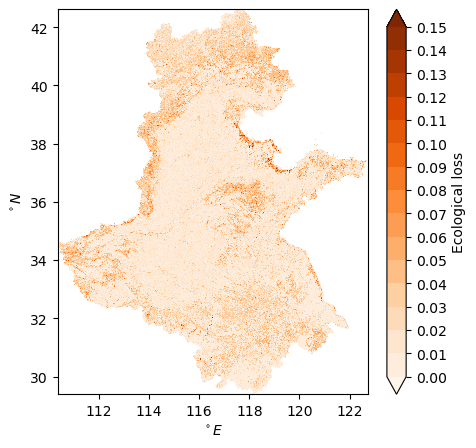

In [32]:
fig,ax = plt.subplots(figsize=(5,5))
clipped.L.loc[{"time":2001}].plot(ax=ax,cmap="Oranges",levels=[i*0.01 for i in range(0,16)],cbar_kwargs={'label':'Ecological loss',"ticks":[i*0.01 for i in range(0,16)]})
ax.set_title("")
ax.set_xlabel('$^\circ E$')
ax.set_ylabel('$^\circ N$')

In [33]:
l.to_netcdf(r"E:\risk_evaluation\scripts\outputs\ECO_LOSS\ecological_loss.nc")